In [ ]:
!pip3 install d2l==1.0.0a0

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [6]:
# Defining the Model
class LinearRegressionScratch(d2l.Module):  
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

In [7]:
@d2l.add_to_class(LinearRegressionScratch) 
def forward(self, X):
    """The linear regression model."""
    return torch.matmul(X, self.w) + self.b

In [9]:
# Defining the Loss Function
@d2l.add_to_class(LinearRegressionScratch)  
def loss(self, y_hat, y):
    l = (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
    return l.mean()

In [10]:
# Defining the Optimization Algorithm
class SGD(d2l.HyperParameters):  
    def __init__(self, params, lr):
        """Minibatch stochastic gradient descent."""
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [11]:
@d2l.add_to_class(LinearRegressionScratch)  
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [12]:
# Training
@d2l.add_to_class(d2l.Trainer)  
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

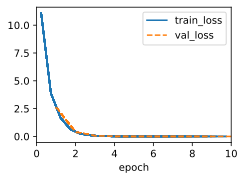

In [14]:
# Result
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [15]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([-0.0004, -0.0008], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0002], grad_fn=<RsubBackward1>)
